In [ ]:
!pip install split-folders -q

In [ ]:
# import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip file

!unzip -q "/content/drive/MyDrive/Copy of Real and Fake Face Detection Dataset.zip" -d "/content/drive/MyDrive/real_and_fake"


In [ ]:
import splitfolders

input_folder = '/content/drive/MyDrive/real_and_fake/Real and Fake Face Detection Dataset'
output_folder = '/content/drive/MyDrive/real_and_fake/real_and_fake_face_new'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.85, 0.15))

Copying files: 2041 files [01:49, 18.68 files/s]


In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224,224)

In [ ]:
train_data_dir = "/content/drive/MyDrive/real_and_fake/real_and_fake_face_new/train"
test_data_dir = "/content/drive/MyDrive/real_and_fake/real_and_fake_face_new/val"

def prepare_data(BATCH_SIZE,IMAGE_SIZE):
  train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMAGE_SIZE,
                                                          subset='training',
                                                          validation_split=0.15,
                                                          seed=42)

  validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMAGE_SIZE,
                                                          subset='validation',
                                                          validation_split=0.15,
                                                          seed=42)

  test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMAGE_SIZE)

  return train_data, validation_data, test_data


train_data, validation_data, test_data = prepare_data(BATCH_SIZE,IMAGE_SIZE)

Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names
class_names

['Fake', 'Real']

In [ ]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(64, 224, 224, 3)
(64,)


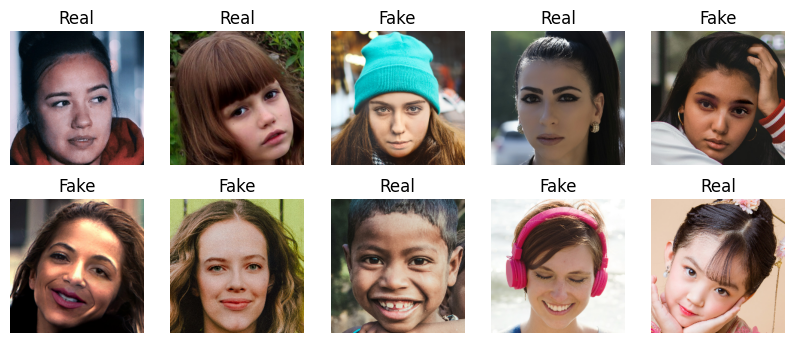

In [ ]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [ ]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

### Model Building

In [ ]:
def pretrain_model(pre_train_model):

  image_shape = (224,224,3)

  if pre_train_model == 'xception':
    main_model = tf.keras.applications.Xception(include_top=False,
                                                input_shape=image_shape,
                                                weights="imagenet")

  if pre_train_model == 'densenet121':
    main_model = tf.keras.applications.DenseNet121(include_top=False,
                                                   input_shape=image_shape,
                                                   weights='imagenet')

  for layers in main_model.layers: # Freeze the layer
    layers.trainable = False

  return main_model

In [ ]:
def create_model(main_model,drop_rate,batch_norm):
  model = tf.keras.models.Sequential()

  model.add(data_augmentation)

  model.add(main_model)

  model.add(tf.keras.layers.GlobalAveragePooling2D())

  if batch_norm == True:
    model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  return model

In [ ]:
main_model = pretrain_model(pre_train_model='densenet121')

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model = create_model(main_model,
                       drop_rate = 0.3,
                       batch_norm = True)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
]

In [ ]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                      callbacks=callbacks)

Epoch 1/10
24/24 [==============================] - 30s 720ms/step - loss: 0.9423 - accuracy: 0.5387 - val_loss: 0.9525 - val_accuracy: 0.4769
Epoch 2/10
24/24 [==============================] - 17s 557ms/step - loss: 0.8528 - accuracy: 0.6099 - val_loss: 0.9222 - val_accuracy: 0.5038
Epoch 3/10
24/24 [==============================] - 21s 654ms/step - loss: 0.7964 - accuracy: 0.6350 - val_loss: 0.8808 - val_accuracy: 0.5154
Epoch 4/10
24/24 [==============================] - 20s 652ms/step - loss: 0.7446 - accuracy: 0.6662 - val_loss: 0.8344 - val_accuracy: 0.5462
Epoch 5/10
24/24 [==============================] - 17s 559ms/step - loss: 0.7286 - accuracy: 0.6730 - val_loss: 0.8242 - val_accuracy: 0.5615
Epoch 6/10
24/24 [==============================] - 18s 514ms/step - loss: 0.7021 - accuracy: 0.7008 - val_loss: 0.8182 - val_accuracy: 0.5692
Epoch 7/10
24/24 [==============================] - 17s 547ms/step - loss: 0.6960 - accuracy: 0.7056 - val_loss: 0.8281 - val_accuracy: 0.5769

### Hyperparameter tuning

In [ ]:
!pip install wandb
import wandb
from wandb.integration.keras import WandbCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers,models

In [ ]:
def pretrain_model_wandb(pre_train_model,bs,fc_size,batch_norm,freez_before,l2_reg,lr,opt,WandB):

  img_height = 224
  img_width = 224

  train_data, val_data, test_data = prepare_data(BATCH_SIZE = bs ,IMAGE_SIZE = (img_height,img_width))

  if pre_train_model == 'xception':
    base_model = tf.keras.applications.Xception(include_top=False,
                                                input_shape=(img_height, img_width,3),
                                                weights="imagenet")

  if pre_train_model == 'densenet121':
    base_model = tf.keras.applications.DenseNet121(include_top=False,
                                                   input_shape=(img_height, img_width,3),
                                                   weights='imagenet')

  for layers in base_model.layers:
    layers.trainable = False
  if freez_before:
    for layer in base_model.layers[-freez_before:]:
      layer.trainable=True

  model = tf.keras.models.Sequential()

  model.add(data_augmentation)
  model.add(base_model)
  model.add(tf.keras.layers.GlobalAveragePooling2D())

  if l2_reg:
    model.add(tf.keras.layers.Dense(units=fc_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  else:
    model.add(tf.keras.layers.Dense(units=fc_size, activation='relu'))

  if batch_norm:
    model.add(BatchNormalization())


  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  optimizers = {
    'adam': tf.keras.optimizers.Adam(learning_rate=lr),
    'sgd': tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    'nadam': tf.keras.optimizers.Nadam(learning_rate=lr)
  }

  model.compile(optimizer = optimizers[opt],
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

  if WandB:
    history2 = model.fit(train_data,epochs=10,validation_data=val_data,callbacks = [WandbCallback()])
  else:
    history2 = model.fit(train_data,epochs=20,validation_data=val_data)

  return model,history2

In [ ]:
sweep_config = {
    'name': 'sweep1',
    'method': 'random', #random, bayes, grid
    'metric' : {
    'name': 'val_accuracy',
    'goal': 'maximize'
    },
    'parameters': {

        'pre_train_model': {
            'values': ['densenet121']
        },
        'dense_size':{
            'values':[128]
        },
        'batch_norm':{
            'values':[True]
        },
        'batch_size_':{
            'values':[64]
        },
        'learing_rate':{
            'values':[0.0001,0.001]
        },
        'freez_before':{
            'values':[0,5]
        },
        'l2_reg':{
            'values':[True,False]
        },
        'opt':{
            'values':['adam','nadam']
        }
  }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DL_DeepFakeProject")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 9uxpn38o
Sweep URL: https://wandb.ai/nuwanthasiriwardhana/DL_DeepFakeProject/sweeps/9uxpn38o


In [ ]:
def train():

    config_defaults = {
        "pre_train_model": 'densenet121',
        "dense_size": 128,
        "batch_norm": True,
        "batch_size_": 64,
        "learing_rate": 0.001,
        "freez_before": 0,
        "l2_reg": True,
        "opt": 'adam'
    }

    wandb.init(config=config_defaults)
    config = wandb.config
    wandb.init(name="model"+str(config.pre_train_model)+"_bn_"+str(config.batch_norm)+"_bs_"+str(config.batch_size_)+
               "_lr_"+str(config.learing_rate)+"_ds_"+str(config.dense_size)+"_freez_"+str(config.freez_before)+"_l2_"+str(config.l2_reg)+
               "_opt_"+str(config.opt))

    pretrain_model_wandb(pre_train_model=config.pre_train_model,bs=config.batch_size_,
                           fc_size=config.dense_size,batch_norm=config.batch_norm,
                           freez_before=config.freez_before,l2_reg=config.l2_reg,lr=config.learing_rate,opt=config.opt,WandB=True)

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: z3csxbzd with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121
wandb: Currently logged in as: nuwanthasiriwardhana. Use `wandb login --relogin` to force relogin


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7789 - accuracy: 0.5224

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_122910-z3csxbzd/files/model-best)... Done. 0.1s


24/24 [==============================] - 87s 3s/step - loss: 0.7789 - accuracy: 0.5224 - val_loss: 1.0203 - val_accuracy: 0.5346
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5719

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_122910-z3csxbzd/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6984 - accuracy: 0.5719 - val_loss: 0.8569 - val_accuracy: 0.5423
Epoch 3/10
24/24 [==============================] - 36s 1s/step - loss: 0.6749 - accuracy: 0.5997 - val_loss: 1.0104 - val_accuracy: 0.5038
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.5997

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_122910-z3csxbzd/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6677 - accuracy: 0.5997 - val_loss: 0.7870 - val_accuracy: 0.5538
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6588 - accuracy: 0.6160

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_122910-z3csxbzd/files/model-best)... Done. 0.1s


24/24 [==============================] - 72s 3s/step - loss: 0.6588 - accuracy: 0.6160 - val_loss: 0.7372 - val_accuracy: 0.5538
Epoch 6/10
24/24 [==============================] - 34s 1s/step - loss: 0.6488 - accuracy: 0.6282 - val_loss: 0.9558 - val_accuracy: 0.5000
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.6590 - accuracy: 0.6018 - val_loss: 0.7530 - val_accuracy: 0.5692
Epoch 8/10
24/24 [==============================] - 36s 1s/step - loss: 0.6443 - accuracy: 0.6296 - val_loss: 0.7419 - val_accuracy: 0.5500
Epoch 9/10
24/24 [==============================] - 35s 1s/step - loss: 0.6500 - accuracy: 0.6208 - val_loss: 0.7408 - val_accuracy: 0.5500
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.6269

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_122910-z3csxbzd/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6387 - accuracy: 0.6269 - val_loss: 0.7128 - val_accuracy: 0.5500


accuracy,▁▄▆▆▇█▆█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▂▁
val_accuracy,▅▅▁▆▆▁█▆▆▆
val_loss,█▄█▃▂▇▂▂▂▁
accuracy,0.62687
best_epoch,9
best_val_loss,0.71277
epoch,9
loss,0.63874
val_accuracy,0.55


wandb: Agent Starting Run: ca1nm0ml with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7804 - accuracy: 0.5271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_123858-ca1nm0ml/files/model-best)... Done. 0.1s


24/24 [==============================] - 82s 3s/step - loss: 0.7804 - accuracy: 0.5271 - val_loss: 0.8312 - val_accuracy: 0.5231
Epoch 2/10
24/24 [==============================] - 36s 1s/step - loss: 0.7048 - accuracy: 0.5611 - val_loss: 0.9741 - val_accuracy: 0.5038
Epoch 3/10
24/24 [==============================] - 35s 1s/step - loss: 0.6825 - accuracy: 0.5773 - val_loss: 0.8527 - val_accuracy: 0.5500
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6693 - accuracy: 0.6018 - val_loss: 0.9189 - val_accuracy: 0.5577
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.6147

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_123858-ca1nm0ml/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6534 - accuracy: 0.6147 - val_loss: 0.8151 - val_accuracy: 0.5269
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.5943

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_123858-ca1nm0ml/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6629 - accuracy: 0.5943 - val_loss: 0.7689 - val_accuracy: 0.5077
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.5991

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_123858-ca1nm0ml/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6612 - accuracy: 0.5991 - val_loss: 0.7427 - val_accuracy: 0.5346
Epoch 8/10
24/24 [==============================] - 36s 1s/step - loss: 0.6437 - accuracy: 0.6221 - val_loss: 0.7667 - val_accuracy: 0.4885
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6242

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_123858-ca1nm0ml/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6483 - accuracy: 0.6242 - val_loss: 0.7038 - val_accuracy: 0.5808
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.6309

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_123858-ca1nm0ml/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6464 - accuracy: 0.6309 - val_loss: 0.6989 - val_accuracy: 0.5885


accuracy,▁▃▄▆▇▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▁▂▂▁▁▁
val_accuracy,▃▂▅▆▄▂▄▁▇█
val_loss,▄█▅▇▄▃▂▃▁▁
accuracy,0.63094
best_epoch,9
best_val_loss,0.69888
epoch,9
loss,0.64636
val_accuracy,0.58846


wandb: Agent Starting Run: xj1e3zao with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7688 - accuracy: 0.5516

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_124927-xj1e3zao/files/model-best)... Done. 0.1s


24/24 [==============================] - 87s 3s/step - loss: 0.7688 - accuracy: 0.5516 - val_loss: 0.9802 - val_accuracy: 0.5154
Epoch 2/10
24/24 [==============================] - 36s 1s/step - loss: 0.7046 - accuracy: 0.5583 - val_loss: 1.2563 - val_accuracy: 0.5154
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5794

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_124927-xj1e3zao/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6835 - accuracy: 0.5794 - val_loss: 0.8329 - val_accuracy: 0.5615
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6653 - accuracy: 0.6140 - val_loss: 1.0530 - val_accuracy: 0.5385
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.5746

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_124927-xj1e3zao/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6691 - accuracy: 0.5746 - val_loss: 0.7627 - val_accuracy: 0.5346
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.6140

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_124927-xj1e3zao/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6545 - accuracy: 0.6140 - val_loss: 0.7425 - val_accuracy: 0.5577
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.5957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_124927-xj1e3zao/files/model-best)... Done. 0.1s


24/24 [==============================] - 72s 3s/step - loss: 0.6670 - accuracy: 0.5957 - val_loss: 0.6918 - val_accuracy: 0.5692
Epoch 8/10
24/24 [==============================] - 36s 1s/step - loss: 0.6499 - accuracy: 0.6262 - val_loss: 0.7098 - val_accuracy: 0.5692
Epoch 9/10
24/24 [==============================] - 34s 1s/step - loss: 0.6645 - accuracy: 0.6092 - val_loss: 0.7096 - val_accuracy: 0.5654
Epoch 10/10
24/24 [==============================] - 35s 1s/step - loss: 0.6454 - accuracy: 0.6221 - val_loss: 0.7220 - val_accuracy: 0.5577


accuracy,▁▂▄▇▃▇▅█▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▂▁
val_accuracy,▁▁▇▄▄▆██▇▆
val_loss,▅█▃▅▂▂▁▁▁▁
accuracy,0.62212
best_epoch,6
best_val_loss,0.69184
epoch,9
loss,0.64539
val_accuracy,0.55769


wandb: Agent Starting Run: kpl80z26 with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.0001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.4912

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 88s 3s/step - loss: 0.7967 - accuracy: 0.4912 - val_loss: 1.1247 - val_accuracy: 0.4731
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.5136

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7593 - accuracy: 0.5136 - val_loss: 0.8864 - val_accuracy: 0.5077
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7216 - accuracy: 0.5488

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7216 - accuracy: 0.5488 - val_loss: 0.7940 - val_accuracy: 0.5077
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.5522

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7110 - accuracy: 0.5522 - val_loss: 0.7795 - val_accuracy: 0.5192
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.5563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.7096 - accuracy: 0.5563 - val_loss: 0.7393 - val_accuracy: 0.5346
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6922 - accuracy: 0.5672 - val_loss: 0.7190 - val_accuracy: 0.5692
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.5801

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.6868 - accuracy: 0.5801 - val_loss: 0.7186 - val_accuracy: 0.5769
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5760

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_125916-kpl80z26/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6839 - accuracy: 0.5760 - val_loss: 0.7089 - val_accuracy: 0.5846
Epoch 9/10
24/24 [==============================] - 34s 1s/step - loss: 0.6834 - accuracy: 0.5678 - val_loss: 0.7092 - val_accuracy: 0.5769
Epoch 10/10
24/24 [==============================] - 36s 1s/step - loss: 0.6816 - accuracy: 0.5821 - val_loss: 0.7154 - val_accuracy: 0.5846


accuracy,▁▃▅▆▆▇██▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▃▃▃▂▁▁▁▁
val_accuracy,▁▃▃▄▅▇████
val_loss,█▄▂▂▂▁▁▁▁▁
accuracy,0.58209
best_epoch,7
best_val_loss,0.70891
epoch,9
loss,0.68161
val_accuracy,0.58462


wandb: Agent Starting Run: 0lpgfww2 with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: True
wandb: 	learing_rate: 0.001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.9765 - accuracy: 0.5142

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_131106-0lpgfww2/files/model-best)... Done. 0.1s


24/24 [==============================] - 85s 3s/step - loss: 0.9765 - accuracy: 0.5142 - val_loss: 1.4706 - val_accuracy: 0.5308
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.8770 - accuracy: 0.5502

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_131106-0lpgfww2/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.8770 - accuracy: 0.5502 - val_loss: 1.0150 - val_accuracy: 0.5115
Epoch 3/10
24/24 [==============================] - 35s 1s/step - loss: 0.7980 - accuracy: 0.5950 - val_loss: 1.2452 - val_accuracy: 0.5115
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.7858 - accuracy: 0.5929 - val_loss: 1.0290 - val_accuracy: 0.5462
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7512 - accuracy: 0.6289

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_131106-0lpgfww2/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.7512 - accuracy: 0.6289 - val_loss: 0.9523 - val_accuracy: 0.5077
Epoch 6/10
24/24 [==============================] - 36s 1s/step - loss: 0.7507 - accuracy: 0.6011 - val_loss: 1.0136 - val_accuracy: 0.4692
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.7479 - accuracy: 0.6113

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_131106-0lpgfww2/files/model-best)... Done. 0.1s


24/24 [==============================] - 72s 3s/step - loss: 0.7479 - accuracy: 0.6113 - val_loss: 0.8403 - val_accuracy: 0.5462
Epoch 8/10
24/24 [==============================] - 35s 1s/step - loss: 0.7341 - accuracy: 0.6391 - val_loss: 0.9022 - val_accuracy: 0.5308
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.6330

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_131106-0lpgfww2/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7309 - accuracy: 0.6330 - val_loss: 0.8223 - val_accuracy: 0.5808
Epoch 10/10
24/24 [==============================] - 35s 1s/step - loss: 0.7251 - accuracy: 0.6323 - val_loss: 0.8273 - val_accuracy: 0.5769


accuracy,▁▃▆▅▇▆▆███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▅▄▄▆▃▁▆▅██
val_loss,█▃▆▃▂▃▁▂▁▁
accuracy,0.63229
best_epoch,8
best_val_loss,0.82232
epoch,9
loss,0.72507
val_accuracy,0.57692


wandb: Agent Starting Run: elgpnmxn with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 5
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.5109

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_132055-elgpnmxn/files/model-best)... Done. 0.1s


24/24 [==============================] - 86s 3s/step - loss: 0.7969 - accuracy: 0.5109 - val_loss: 0.8759 - val_accuracy: 0.5731
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5706

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_132055-elgpnmxn/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6961 - accuracy: 0.5706 - val_loss: 0.7764 - val_accuracy: 0.5654
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.6011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_132055-elgpnmxn/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.6718 - accuracy: 0.6011 - val_loss: 0.7607 - val_accuracy: 0.5731
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6693 - accuracy: 0.5943

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_132055-elgpnmxn/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6693 - accuracy: 0.5943 - val_loss: 0.7264 - val_accuracy: 0.6038
Epoch 5/10
24/24 [==============================] - 34s 1s/step - loss: 0.6592 - accuracy: 0.6113 - val_loss: 0.8335 - val_accuracy: 0.5769
Epoch 6/10
24/24 [==============================] - 36s 1s/step - loss: 0.6600 - accuracy: 0.6160 - val_loss: 0.9147 - val_accuracy: 0.5615
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.6583 - accuracy: 0.5997 - val_loss: 0.9748 - val_accuracy: 0.5500
Epoch 8/10
24/24 [==============================] - 35s 1s/step - loss: 0.6389 - accuracy: 0.6187 - val_loss: 0.7415 - val_accuracy: 0.6231
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.6343

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_132055-elgpnmxn/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6470 - accuracy: 0.6343 - val_loss: 0.7168 - val_accuracy: 0.6192
Epoch 10/10
24/24 [==============================] - 34s 1s/step - loss: 0.6403 - accuracy: 0.6201 - val_loss: 0.7251 - val_accuracy: 0.5846


accuracy,▁▄▆▆▇▇▆▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▂▂▂▁▁▁
val_accuracy,▃▂▃▆▄▂▁██▄
val_loss,▅▃▂▁▄▆█▂▁▁
accuracy,0.62008
best_epoch,8
best_val_loss,0.71678
epoch,9
loss,0.6403
val_accuracy,0.58462


wandb: Agent Starting Run: 0h0pm009 with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.0001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.4932

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_133047-0h0pm009/files/model-best)... Done. 0.1s


24/24 [==============================] - 86s 3s/step - loss: 0.8448 - accuracy: 0.4932 - val_loss: 1.1963 - val_accuracy: 0.4769
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7737 - accuracy: 0.5122

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_133047-0h0pm009/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.7737 - accuracy: 0.5122 - val_loss: 0.8540 - val_accuracy: 0.5115
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.5271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_133047-0h0pm009/files/model-best)... Done. 0.1s


24/24 [==============================] - 72s 3s/step - loss: 0.7573 - accuracy: 0.5271 - val_loss: 0.8078 - val_accuracy: 0.5385
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.5597

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_133047-0h0pm009/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.7302 - accuracy: 0.5597 - val_loss: 0.7678 - val_accuracy: 0.5462
Epoch 5/10
24/24 [==============================] - 34s 1s/step - loss: 0.7107 - accuracy: 0.5563 - val_loss: 0.7860 - val_accuracy: 0.5577
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.7006 - accuracy: 0.5733 - val_loss: 0.7924 - val_accuracy: 0.5385
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.5645

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_133047-0h0pm009/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.7020 - accuracy: 0.5645 - val_loss: 0.7649 - val_accuracy: 0.5615
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.5828

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_133047-0h0pm009/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6807 - accuracy: 0.5828 - val_loss: 0.7476 - val_accuracy: 0.5692
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.5834

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_133047-0h0pm009/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6769 - accuracy: 0.5834 - val_loss: 0.7171 - val_accuracy: 0.5885
Epoch 10/10
24/24 [==============================] - 34s 1s/step - loss: 0.6762 - accuracy: 0.5923 - val_loss: 0.7240 - val_accuracy: 0.5808


accuracy,▁▂▃▆▅▇▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▅▆▇██
val_loss,█▃▂▂▂▂▂▁▁▁
accuracy,0.59227
best_epoch,8
best_val_loss,0.71706
epoch,9
loss,0.6762
val_accuracy,0.58077


wandb: Agent Starting Run: 1qkis8ut with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 5
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.8167 - accuracy: 0.5102

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_134147-1qkis8ut/files/model-best)... Done. 0.1s


24/24 [==============================] - 89s 3s/step - loss: 0.8167 - accuracy: 0.5102 - val_loss: 1.1955 - val_accuracy: 0.5154
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.5482

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_134147-1qkis8ut/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7193 - accuracy: 0.5482 - val_loss: 0.9465 - val_accuracy: 0.5577
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.5936

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_134147-1qkis8ut/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6777 - accuracy: 0.5936 - val_loss: 0.7449 - val_accuracy: 0.5269
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6677 - accuracy: 0.5787 - val_loss: 0.9503 - val_accuracy: 0.5538
Epoch 5/10
24/24 [==============================] - 35s 1s/step - loss: 0.6550 - accuracy: 0.6140 - val_loss: 1.0567 - val_accuracy: 0.5462
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.6609 - accuracy: 0.6119 - val_loss: 1.0232 - val_accuracy: 0.5462
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.6432 - accuracy: 0.6275 - val_loss: 0.7727 - val_accuracy: 0.5577
Epoch 8/10
24/24 [==============================] - 35s 1s/step - loss: 0.6548 - accuracy: 0.6316 - val_loss: 0.7711 - val_accuracy: 0.5500
Epoch 9/10
24/24 [==============================] - 35s 1s/step - loss: 0.6412 - accuracy: 0.6309 - val_loss: 0.8431 - val_accuracy: 0.5500
Epoch 10/10
24/24 [============

accuracy,▁▃▆▅▇▇███▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▂▂▁▂▁▂
val_accuracy,▁█▃▇▆▆█▇▇▇
val_loss,█▄▁▄▆▅▁▁▃▃
accuracy,0.61058
best_epoch,2
best_val_loss,0.74494
epoch,9
loss,0.65515
val_accuracy,0.55385


wandb: Agent Starting Run: 3a9bbvoq with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7757 - accuracy: 0.5468

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_135023-3a9bbvoq/files/model-best)... Done. 0.1s


24/24 [==============================] - 86s 3s/step - loss: 0.7757 - accuracy: 0.5468 - val_loss: 1.1274 - val_accuracy: 0.5154
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.5583

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_135023-3a9bbvoq/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.7137 - accuracy: 0.5583 - val_loss: 0.8823 - val_accuracy: 0.4962
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.5570

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_135023-3a9bbvoq/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.7004 - accuracy: 0.5570 - val_loss: 0.7762 - val_accuracy: 0.5077
Epoch 4/10
24/24 [==============================] - 34s 1s/step - loss: 0.6780 - accuracy: 0.5848 - val_loss: 0.8259 - val_accuracy: 0.5731
Epoch 5/10
24/24 [==============================] - 34s 1s/step - loss: 0.6633 - accuracy: 0.5991 - val_loss: 0.7905 - val_accuracy: 0.5654
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.6546 - accuracy: 0.6201 - val_loss: 0.8041 - val_accuracy: 0.5231
Epoch 7/10
24/24 [==============================] - 34s 1s/step - loss: 0.6626 - accuracy: 0.6011 - val_loss: 0.7815 - val_accuracy: 0.5500
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.6201

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_135023-3a9bbvoq/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6467 - accuracy: 0.6201 - val_loss: 0.7454 - val_accuracy: 0.5654
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.6404

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_135023-3a9bbvoq/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6370 - accuracy: 0.6404 - val_loss: 0.7418 - val_accuracy: 0.5154
Epoch 10/10
24/24 [==============================] - 35s 1s/step - loss: 0.6476 - accuracy: 0.6208 - val_loss: 0.8115 - val_accuracy: 0.5692


accuracy,▁▂▂▄▅▆▅▆█▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▂
val_accuracy,▃▁▂█▇▃▆▇▃█
val_loss,█▄▂▃▂▂▂▁▁▂
accuracy,0.62076
best_epoch,8
best_val_loss,0.74178
epoch,9
loss,0.6476
val_accuracy,0.56923


wandb: Agent Starting Run: 7qoqn7t4 with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: True
wandb: 	learing_rate: 0.001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.5176

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140014-7qoqn7t4/files/model-best)... Done. 0.1s


24/24 [==============================] - 90s 4s/step - loss: 0.9645 - accuracy: 0.5176 - val_loss: 1.1802 - val_accuracy: 0.5038
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.8462 - accuracy: 0.5448

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140014-7qoqn7t4/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.8462 - accuracy: 0.5448 - val_loss: 0.9497 - val_accuracy: 0.5308
Epoch 3/10
24/24 [==============================] - 34s 1s/step - loss: 0.7903 - accuracy: 0.5706 - val_loss: 0.9840 - val_accuracy: 0.5115
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.5957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140014-7qoqn7t4/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.7711 - accuracy: 0.5957 - val_loss: 0.8978 - val_accuracy: 0.5808
Epoch 5/10
24/24 [==============================] - 36s 1s/step - loss: 0.7460 - accuracy: 0.6079 - val_loss: 1.0744 - val_accuracy: 0.4808
Epoch 6/10
24/24 [==============================] - 34s 1s/step - loss: 0.7391 - accuracy: 0.6140 - val_loss: 0.9434 - val_accuracy: 0.5000
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.7490 - accuracy: 0.6024 - val_loss: 0.9271 - val_accuracy: 0.5308
Epoch 8/10
24/24 [==============================] - 34s 1s/step - loss: 0.7293 - accuracy: 0.6255 - val_loss: 0.8988 - val_accuracy: 0.4808
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6289

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140014-7qoqn7t4/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7331 - accuracy: 0.6289 - val_loss: 0.7770 - val_accuracy: 0.5769
Epoch 10/10
24/24 [==============================] - 36s 1s/step - loss: 0.7200 - accuracy: 0.6208 - val_loss: 0.8671 - val_accuracy: 0.5346


accuracy,▁▃▄▆▇▇▆██▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▂▁▁▁
val_accuracy,▃▅▃█▁▂▅▁█▅
val_loss,█▄▅▃▆▄▄▃▁▃
accuracy,0.62076
best_epoch,8
best_val_loss,0.77699
epoch,9
loss,0.72002
val_accuracy,0.53462


wandb: Agent Starting Run: ycecsmur with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 5
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7764 - accuracy: 0.5366

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140930-ycecsmur/files/model-best)... Done. 0.1s


24/24 [==============================] - 86s 3s/step - loss: 0.7764 - accuracy: 0.5366 - val_loss: 0.8525 - val_accuracy: 0.5923
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7199 - accuracy: 0.5455

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140930-ycecsmur/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.7199 - accuracy: 0.5455 - val_loss: 0.8015 - val_accuracy: 0.5808
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5882

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140930-ycecsmur/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6936 - accuracy: 0.5882 - val_loss: 0.7515 - val_accuracy: 0.5808
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6660 - accuracy: 0.6045 - val_loss: 0.9210 - val_accuracy: 0.5731
Epoch 5/10
24/24 [==============================] - 34s 1s/step - loss: 0.6585 - accuracy: 0.6018 - val_loss: 0.7914 - val_accuracy: 0.5769
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.6447 - accuracy: 0.6248 - val_loss: 0.8397 - val_accuracy: 0.5500
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.6470 - accuracy: 0.6113 - val_loss: 0.7576 - val_accuracy: 0.5808
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6296

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_140930-ycecsmur/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6418 - accuracy: 0.6296 - val_loss: 0.7325 - val_accuracy: 0.5885
Epoch 9/10
24/24 [==============================] - 34s 1s/step - loss: 0.6478 - accuracy: 0.6201 - val_loss: 0.7530 - val_accuracy: 0.5269
Epoch 10/10
24/24 [==============================] - 34s 1s/step - loss: 0.6417 - accuracy: 0.6187 - val_loss: 0.7420 - val_accuracy: 0.5615


accuracy,▁▂▅▆▆█▇█▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▂▂▁▁▁▁▁
val_accuracy,█▇▇▆▆▃▇█▁▅
val_loss,▅▄▂█▃▅▂▁▂▁
accuracy,0.61872
best_epoch,7
best_val_loss,0.73245
epoch,9
loss,0.64168
val_accuracy,0.56154


wandb: Agent Starting Run: x8588f7u with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 5
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.5258

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_141841-x8588f7u/files/model-best)... Done. 0.1s


24/24 [==============================] - 89s 3s/step - loss: 0.7705 - accuracy: 0.5258 - val_loss: 0.8689 - val_accuracy: 0.5385
Epoch 2/10
24/24 [==============================] - 35s 1s/step - loss: 0.6943 - accuracy: 0.5889 - val_loss: 1.0051 - val_accuracy: 0.5538
Epoch 3/10
24/24 [==============================] - 36s 1s/step - loss: 0.6829 - accuracy: 0.5916 - val_loss: 0.9102 - val_accuracy: 0.5500
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6646 - accuracy: 0.6235 - val_loss: 1.1433 - val_accuracy: 0.5538
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.6330

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_141841-x8588f7u/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6415 - accuracy: 0.6330 - val_loss: 0.7987 - val_accuracy: 0.5500
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.6545 - accuracy: 0.6255 - val_loss: 0.8507 - val_accuracy: 0.5385
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.6011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_141841-x8588f7u/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6590 - accuracy: 0.6011 - val_loss: 0.7683 - val_accuracy: 0.5577
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.6228

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_141841-x8588f7u/files/model-best)... Done. 0.1s


24/24 [==============================] - 77s 3s/step - loss: 0.6486 - accuracy: 0.6228 - val_loss: 0.7582 - val_accuracy: 0.5731
Epoch 9/10
24/24 [==============================] - 35s 1s/step - loss: 0.6338 - accuracy: 0.6350 - val_loss: 0.7625 - val_accuracy: 0.5385
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.6343

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_141841-x8588f7u/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6414 - accuracy: 0.6343 - val_loss: 0.7537 - val_accuracy: 0.5538


accuracy,▁▅▅▇█▇▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▁▂▂▂▁▁
val_accuracy,▁▄▃▄▃▁▅█▁▄
val_loss,▃▆▄█▂▃▁▁▁▁
accuracy,0.63433
best_epoch,9
best_val_loss,0.75368
epoch,9
loss,0.64136
val_accuracy,0.55385


wandb: Agent Starting Run: wtofzxaq with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.8010 - accuracy: 0.5054

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_142839-wtofzxaq/files/model-best)... Done. 0.1s


24/24 [==============================] - 91s 3s/step - loss: 0.8010 - accuracy: 0.5054 - val_loss: 1.1102 - val_accuracy: 0.5385
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.5529

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_142839-wtofzxaq/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.7083 - accuracy: 0.5529 - val_loss: 0.7579 - val_accuracy: 0.5577
Epoch 3/10
24/24 [==============================] - 35s 1s/step - loss: 0.6743 - accuracy: 0.6092 - val_loss: 0.8641 - val_accuracy: 0.5615
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6739 - accuracy: 0.6011 - val_loss: 0.7844 - val_accuracy: 0.5654
Epoch 5/10
24/24 [==============================] - 36s 1s/step - loss: 0.6552 - accuracy: 0.6208 - val_loss: 0.8153 - val_accuracy: 0.5538
Epoch 6/10
24/24 [==============================] - 34s 1s/step - loss: 0.6665 - accuracy: 0.5963 - val_loss: 0.7702 - val_accuracy: 0.5115
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.5902

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_142839-wtofzxaq/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6641 - accuracy: 0.5902 - val_loss: 0.7336 - val_accuracy: 0.5423
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6174

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_142839-wtofzxaq/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6513 - accuracy: 0.6174 - val_loss: 0.7275 - val_accuracy: 0.6038
Epoch 9/10
24/24 [==============================] - 34s 1s/step - loss: 0.6574 - accuracy: 0.6072 - val_loss: 0.7507 - val_accuracy: 0.5269
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.6248

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_142839-wtofzxaq/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6494 - accuracy: 0.6248 - val_loss: 0.7028 - val_accuracy: 0.5692


accuracy,▁▄▇▇█▆▆█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▁▂▂▁▁▁
val_accuracy,▃▅▅▅▄▁▃█▂▅
val_loss,█▂▄▂▃▂▂▁▂▁
accuracy,0.62483
best_epoch,9
best_val_loss,0.70275
epoch,9
loss,0.64937
val_accuracy,0.56923


wandb: Agent Starting Run: 8nzqwr76 with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7915 - accuracy: 0.5068

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_143836-8nzqwr76/files/model-best)... Done. 0.1s


24/24 [==============================] - 88s 3s/step - loss: 0.7915 - accuracy: 0.5068 - val_loss: 1.2901 - val_accuracy: 0.5115
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.5461

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_143836-8nzqwr76/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7090 - accuracy: 0.5461 - val_loss: 1.2278 - val_accuracy: 0.5154
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5746

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_143836-8nzqwr76/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.6840 - accuracy: 0.5746 - val_loss: 1.1827 - val_accuracy: 0.4538
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6733 - accuracy: 0.5834 - val_loss: 1.2226 - val_accuracy: 0.5500
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6018

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_143836-8nzqwr76/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.6659 - accuracy: 0.6018 - val_loss: 0.7681 - val_accuracy: 0.5192
Epoch 6/10
24/24 [==============================] - 36s 1s/step - loss: 0.6494 - accuracy: 0.6187 - val_loss: 0.7835 - val_accuracy: 0.5346
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.6669 - accuracy: 0.5902 - val_loss: 0.7706 - val_accuracy: 0.5500
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.6085

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_143836-8nzqwr76/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6507 - accuracy: 0.6085 - val_loss: 0.7609 - val_accuracy: 0.5038
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.6242

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_143836-8nzqwr76/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.6535 - accuracy: 0.6242 - val_loss: 0.7405 - val_accuracy: 0.5462
Epoch 10/10
24/24 [==============================] - 36s 1s/step - loss: 0.6468 - accuracy: 0.6343 - val_loss: 0.7733 - val_accuracy: 0.5692


accuracy,▁▃▅▅▆▇▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▂▁▁▁
val_accuracy,▄▅▁▇▅▆▇▄▇█
val_loss,█▇▇▇▁▂▁▁▁▁
accuracy,0.63433
best_epoch,8
best_val_loss,0.74046
epoch,9
loss,0.64677
val_accuracy,0.56923


wandb: Agent Starting Run: dfb554lk with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: True
wandb: 	learing_rate: 0.0001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.5047

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 88s 3s/step - loss: 0.9911 - accuracy: 0.5047 - val_loss: 1.0430 - val_accuracy: 0.5538
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.9452 - accuracy: 0.5434

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.9452 - accuracy: 0.5434 - val_loss: 0.9924 - val_accuracy: 0.5462
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.9157 - accuracy: 0.5536

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.9157 - accuracy: 0.5536 - val_loss: 0.9687 - val_accuracy: 0.5538
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.8962 - accuracy: 0.5522

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.8962 - accuracy: 0.5522 - val_loss: 0.9548 - val_accuracy: 0.5538
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.8872 - accuracy: 0.5685

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.8872 - accuracy: 0.5685 - val_loss: 0.9346 - val_accuracy: 0.5692
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.8588 - accuracy: 0.5841

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.8588 - accuracy: 0.5841 - val_loss: 0.9215 - val_accuracy: 0.5808
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.5780

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 77s 3s/step - loss: 0.8613 - accuracy: 0.5780 - val_loss: 0.9192 - val_accuracy: 0.5500
Epoch 8/10
24/24 [==============================] - 36s 1s/step - loss: 0.8418 - accuracy: 0.5929 - val_loss: 0.9334 - val_accuracy: 0.5269
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.8404 - accuracy: 0.5685

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.8404 - accuracy: 0.5685 - val_loss: 0.8950 - val_accuracy: 0.5731
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.8245 - accuracy: 0.6031

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_144914-dfb554lk/files/model-best)... Done. 0.1s


24/24 [==============================] - 78s 3s/step - loss: 0.8245 - accuracy: 0.6031 - val_loss: 0.8916 - val_accuracy: 0.5692


accuracy,▁▄▄▄▆▇▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▂▃▂▂▁
val_accuracy,▅▄▅▅▇█▄▁▇▇
val_loss,█▆▅▄▃▂▂▃▁▁
accuracy,0.60312
best_epoch,9
best_val_loss,0.89156
epoch,9
loss,0.82449
val_accuracy,0.56923


wandb: Agent Starting Run: 7wlaf5kg with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.0001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7795 - accuracy: 0.5217

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_150155-7wlaf5kg/files/model-best)... Done. 0.1s


24/24 [==============================] - 91s 4s/step - loss: 0.7795 - accuracy: 0.5217 - val_loss: 0.8375 - val_accuracy: 0.5038
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.5061

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_150155-7wlaf5kg/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.7575 - accuracy: 0.5061 - val_loss: 0.7986 - val_accuracy: 0.5308
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.5299

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_150155-7wlaf5kg/files/model-best)... Done. 0.1s


24/24 [==============================] - 77s 3s/step - loss: 0.7305 - accuracy: 0.5299 - val_loss: 0.7795 - val_accuracy: 0.5231
Epoch 4/10
24/24 [==============================] - 34s 1s/step - loss: 0.7174 - accuracy: 0.5441 - val_loss: 0.7799 - val_accuracy: 0.5000
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5495

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_150155-7wlaf5kg/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.7040 - accuracy: 0.5495 - val_loss: 0.7750 - val_accuracy: 0.5038
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.6893 - accuracy: 0.5801 - val_loss: 0.7751 - val_accuracy: 0.4923
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.6983 - accuracy: 0.5746 - val_loss: 0.7752 - val_accuracy: 0.5154
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5794

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_150155-7wlaf5kg/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6804 - accuracy: 0.5794 - val_loss: 0.7662 - val_accuracy: 0.5154
Epoch 9/10
24/24 [==============================] - 35s 1s/step - loss: 0.6921 - accuracy: 0.5522 - val_loss: 0.7902 - val_accuracy: 0.5308
Epoch 10/10
24/24 [==============================] - 34s 1s/step - loss: 0.6829 - accuracy: 0.5739 - val_loss: 0.7854 - val_accuracy: 0.5308


accuracy,▂▁▃▅▅█▇█▅▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▁▂▁
val_accuracy,▃█▇▂▃▁▅▅██
val_loss,█▄▂▂▂▂▂▁▃▃
accuracy,0.57395
best_epoch,7
best_val_loss,0.76625
epoch,9
loss,0.68293
val_accuracy,0.53077


wandb: Agent Starting Run: bcah7v4c with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 0
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.5224

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_151154-bcah7v4c/files/model-best)... Done. 0.1s


24/24 [==============================] - 89s 3s/step - loss: 0.7748 - accuracy: 0.5224 - val_loss: 0.8802 - val_accuracy: 0.5538
Epoch 2/10
24/24 [==============================] - 34s 1s/step - loss: 0.7075 - accuracy: 0.5678 - val_loss: 0.8821 - val_accuracy: 0.5346
Epoch 3/10
24/24 [==============================] - 35s 1s/step - loss: 0.6697 - accuracy: 0.5929 - val_loss: 0.9224 - val_accuracy: 0.5231
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.6133

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_151154-bcah7v4c/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6683 - accuracy: 0.6133 - val_loss: 0.7891 - val_accuracy: 0.5846
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.5991

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_151154-bcah7v4c/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6599 - accuracy: 0.5991 - val_loss: 0.7764 - val_accuracy: 0.5308
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.6486 - accuracy: 0.6140 - val_loss: 0.9844 - val_accuracy: 0.4808
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6079

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_151154-bcah7v4c/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.6654 - accuracy: 0.6079 - val_loss: 0.7514 - val_accuracy: 0.5654
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.6018

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_151154-bcah7v4c/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.6525 - accuracy: 0.6018 - val_loss: 0.7354 - val_accuracy: 0.5692
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.6390 - accuracy: 0.6343

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_151154-bcah7v4c/files/model-best)... Done. 0.1s


24/24 [==============================] - 73s 3s/step - loss: 0.6390 - accuracy: 0.6343 - val_loss: 0.7311 - val_accuracy: 0.5423
Epoch 10/10
24/24 [==============================] - 36s 1s/step - loss: 0.6312 - accuracy: 0.6411 - val_loss: 0.8314 - val_accuracy: 0.5615


accuracy,▁▄▅▆▆▆▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▃▂▁▁
val_accuracy,▆▅▄█▄▁▇▇▅▆
val_loss,▅▅▆▃▂█▂▁▁▄
accuracy,0.64111
best_epoch,8
best_val_loss,0.73105
epoch,9
loss,0.63118
val_accuracy,0.56154


wandb: Agent Starting Run: vku00lc5 with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 5
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: adam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7854 - accuracy: 0.5427

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_152235-vku00lc5/files/model-best)... Done. 0.1s


24/24 [==============================] - 85s 3s/step - loss: 0.7854 - accuracy: 0.5427 - val_loss: 0.8291 - val_accuracy: 0.4885
Epoch 2/10
24/24 [==============================] - 36s 1s/step - loss: 0.7196 - accuracy: 0.5658 - val_loss: 0.9645 - val_accuracy: 0.5154
Epoch 3/10
24/24 [==============================] - 35s 1s/step - loss: 0.6965 - accuracy: 0.5889 - val_loss: 0.8297 - val_accuracy: 0.5385
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.6140

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_152235-vku00lc5/files/model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.6612 - accuracy: 0.6140 - val_loss: 0.7690 - val_accuracy: 0.5385
Epoch 5/10
24/24 [==============================] - 36s 1s/step - loss: 0.6501 - accuracy: 0.6242 - val_loss: 0.8011 - val_accuracy: 0.5423
Epoch 6/10
24/24 [==============================] - 35s 1s/step - loss: 0.6527 - accuracy: 0.6309 - val_loss: 0.8022 - val_accuracy: 0.5692
Epoch 7/10
24/24 [==============================] - 34s 1s/step - loss: 0.6683 - accuracy: 0.5997 - val_loss: 0.7701 - val_accuracy: 0.5769
Epoch 8/10
24/24 [==============================] - 36s 1s/step - loss: 0.6469 - accuracy: 0.6201 - val_loss: 0.8638 - val_accuracy: 0.5846
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.6350

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_152235-vku00lc5/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6435 - accuracy: 0.6350 - val_loss: 0.7516 - val_accuracy: 0.5654
Epoch 10/10
24/24 [==============================] - 35s 1s/step - loss: 0.6373 - accuracy: 0.6303 - val_loss: 0.8024 - val_accuracy: 0.5692


accuracy,▁▃▅▆▇█▅▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▅▇▇█▇▇
val_loss,▄█▄▂▃▃▂▅▁▃
accuracy,0.63026
best_epoch,8
best_val_loss,0.75157
epoch,9
loss,0.63728
val_accuracy,0.56923


wandb: Agent Starting Run: ctrkjh55 with config:
wandb: 	batch_norm: True
wandb: 	batch_size_: 64
wandb: 	dense_size: 128
wandb: 	freez_before: 5
wandb: 	l2_reg: False
wandb: 	learing_rate: 0.001
wandb: 	opt: nadam
wandb: 	pre_train_model: densenet121


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.8042 - accuracy: 0.5299

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_153114-ctrkjh55/files/model-best)... Done. 0.1s


24/24 [==============================] - 91s 4s/step - loss: 0.8042 - accuracy: 0.5299 - val_loss: 1.0330 - val_accuracy: 0.5423
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.5807

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_153114-ctrkjh55/files/model-best)... Done. 0.1s


24/24 [==============================] - 74s 3s/step - loss: 0.7144 - accuracy: 0.5807 - val_loss: 0.7920 - val_accuracy: 0.5731
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_153114-ctrkjh55/files/model-best)... Done. 0.1s


24/24 [==============================] - 77s 3s/step - loss: 0.6883 - accuracy: 0.5692 - val_loss: 0.7267 - val_accuracy: 0.5577
Epoch 4/10
24/24 [==============================] - 35s 1s/step - loss: 0.6859 - accuracy: 0.5970 - val_loss: 0.7714 - val_accuracy: 0.5462
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.6201

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_153114-ctrkjh55/files/model-best)... Done. 0.1s


24/24 [==============================] - 75s 3s/step - loss: 0.6449 - accuracy: 0.6201 - val_loss: 0.7233 - val_accuracy: 0.5462
Epoch 6/10
24/24 [==============================] - 37s 2s/step - loss: 0.6464 - accuracy: 0.6208 - val_loss: 0.7412 - val_accuracy: 0.5731
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240714_153114-ctrkjh55/files/model-best)... Done. 0.1s


24/24 [==============================] - 78s 3s/step - loss: 0.6519 - accuracy: 0.6011 - val_loss: 0.7186 - val_accuracy: 0.5731
Epoch 8/10
24/24 [==============================] - 34s 1s/step - loss: 0.6525 - accuracy: 0.6140 - val_loss: 0.7716 - val_accuracy: 0.5615
Epoch 9/10
24/24 [==============================] - 36s 1s/step - loss: 0.6553 - accuracy: 0.6242 - val_loss: 0.7695 - val_accuracy: 0.5615
Epoch 10/10
24/24 [==============================] - 33s 1s/step - loss: 0.6442 - accuracy: 0.6214 - val_loss: 0.7477 - val_accuracy: 0.5577


accuracy,▁▅▄▆██▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▁▁▁▁▁▁
val_accuracy,▁█▅▂▂██▅▅▅
val_loss,█▃▁▂▁▂▁▂▂▂
accuracy,0.62144
best_epoch,6
best_val_loss,0.71858
epoch,9
loss,0.64421
val_accuracy,0.55769


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Best Model

In [ ]:
model2, history2 = pretrain_model_wandb(pre_train_model='densenet121',bs=64,fc_size=128,batch_norm=True,freez_before=0,l2_reg=False,lr=0.001,opt='adam',WandB=False)


Found 1734 files belonging to 2 classes.
Using 1474 files for training.
Found 1734 files belonging to 2 classes.
Using 260 files for validation.
Found 307 files belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 33s 674ms/step - loss: 0.7659 - accuracy: 0.5170 - val_loss: 0.9214 - val_accuracy: 0.5115
Epoch 2/20
24/24 [==============================] - 19s 595ms/step - loss: 0.7170 - accuracy: 0.5563 - val_loss: 0.8746 - val_accuracy: 0.5269
Epoch 3/20
24/24 [==============================] - 20s 587ms/step - loss: 0.6972 - accuracy: 0.5814 - val_loss: 1.2679 - val_accuracy: 0.4731
Epoch 4/20
24/24 [==============================] - 19s 625ms/step - loss: 0.6738 - accuracy: 0.5977 - val_loss: 0.8654 - val_accuracy: 0.5308
Epoch 5/20
24/24 [==============================] - 21s 653ms/step - loss: 0.6600 - accuracy: 0.5991 - val_loss: 0.7178 - val_accuracy: 0.5654
Epoch 6/20
24/24 [==============================] - 19s 617ms/step - loss: 0.6464 - accuracy: 0.6214

In [ ]:
#Save in TensorFlow SavedModel format
model2.save('/content/drive/MyDrive/DeepfakeModel/model2')

In [ ]:
from tensorflow.keras.models import load_model

#load from TensorFlow SavedModel format
loaded_model2 = load_model('/content/drive/MyDrive/DeepfakeModel/model2')

### Performance Analysis

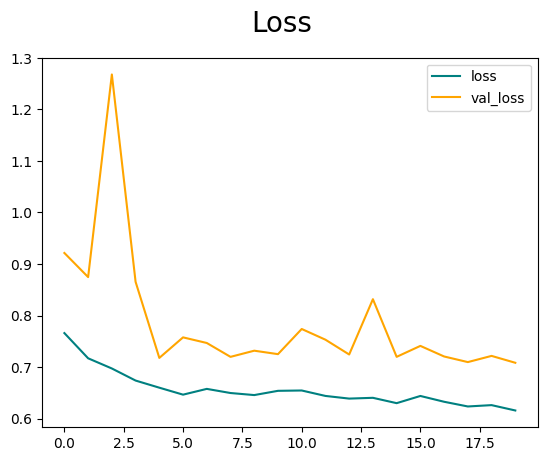

In [ ]:
fig = plt.figure()
plt.plot(history2.history['loss'], color='teal', label='loss')
plt.plot(history2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

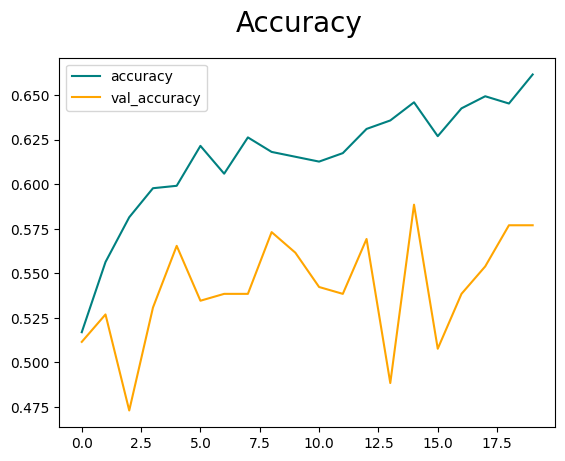

In [ ]:
fig = plt.figure()
plt.plot(history2.history['accuracy'], color='teal', label='accuracy')
plt.plot(history2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

### Model Evaluation

In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [ ]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = loaded_model2.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

2/2 [==============================] - 0s 95ms/step


In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.52895755>

In [ ]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.8404908>

In [ ]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5179153>

5/5 [==============================] - 13s 2s/step
Confusion Matrix:
[[ 17 127]
 [ 31 132]]


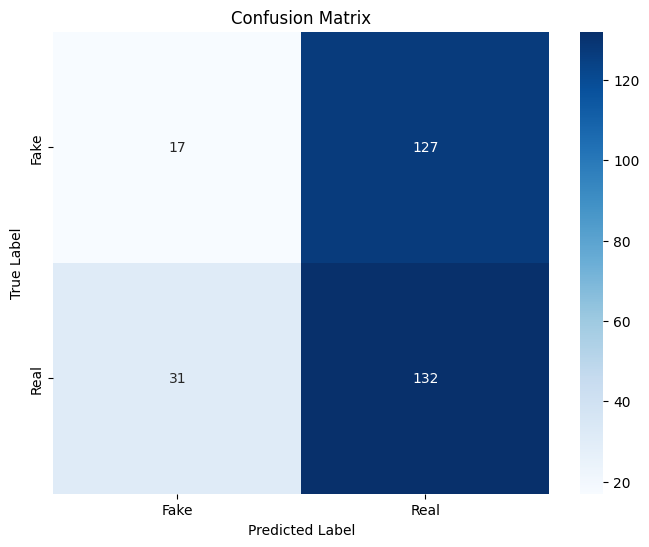

              precision    recall  f1-score   support

        Fake       0.35      0.12      0.18       144
        Real       0.51      0.81      0.63       163

    accuracy                           0.49       307
   macro avg       0.43      0.46      0.40       307
weighted avg       0.44      0.49      0.42       307



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Extract the batches and labels from test data
batches = list(test_data)
true_labels = np.concatenate([y for x, y in batches])

# Predicting and calculating additional metrics
predictions = loaded_model2.predict(test_data)
predictions = (predictions > 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_labels, predictions, target_names=class_names))

### Test

In [ ]:
!pip install opencv-python -q

In [ ]:
import cv2

def image_predict(path):
  img = cv2.imread(path)
  plt.imshow(img)
  plt.title(path.split('/')[-2])
  plt.show()

  resized_image = tf.image.resize(img, IMAGE_SIZE)
  scaled_image = resized_image/255

  yhat = loaded_model2.predict(np.expand_dims(scaled_image, 0))

  if yhat > 0.5:
    print(f'{class_names[1]}')
  else:
    print(f'{class_names[0]}')

  print(yhat)

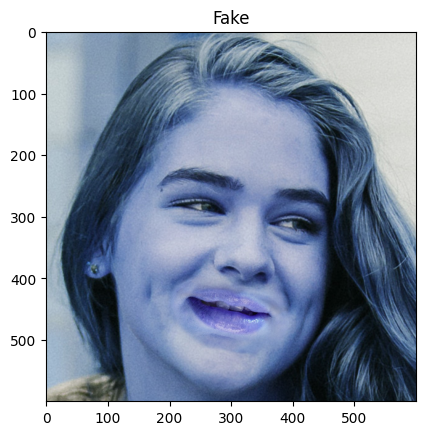

1/1 [==============================] - 5s 5s/step
Real
[[0.5364781]]


In [ ]:
image_predict('/content/drive/MyDrive/real_and_fake/real_and_fake_face_new/val/Fake/easy_94_0001.jpg')